INFO: run with conda environment sc-arches

# 0. Import packages

In [1]:
import os
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import mygene
import pandas as pd

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
sys.path.insert(0,'..')
import paths_downsampling as paths
p = paths.get_paths()
print(p)

{'basedir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/', 'rawdir_RNA': '/psycl/g/mpsngs/HiSeq_Helmholtz/20210324_Anna_Froehlich_10X_RNAseq/03_downsampled/', 'figdir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/figures/', 'writedir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/scanpy_adata/', 'allendir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/reference_data/allen_human/'}


# 1. Load data

In [5]:
source_adata = sc.read(p['allendir']+'adata_sct_umap_allenBrain.h5ad')

In [6]:
cell_type_col = 'subclass_label'

In [7]:
source_adata = source_adata[source_adata.obs[cell_type_col] != 'nan', :]

In [8]:
target_adata = sc.read(p['writedir']+'adata_clustering_SampleFilt.h5ad')

## 1.1 Subset both datasets to same features/genes

A lot of features are lost on this step. However, mapping the ensembl IDs of target_data to entrez IDs still seems to be the best solution - at least the highest number of common genes are left afterwards.

Having only a subset of features (~18000 of 45000) in source dataset increased the prediction accuracy of labels in source dataset from 0.9 to 0.96. --> Does it also work to predict on target dataset?

In [9]:
# read additional gene information for source data - including entrez id
source_gene_meta = pd.read_csv(p['allendir']+'human_MTG_2018-06-14_genes-rows.csv')
source_gene_meta = source_gene_meta[['gene', 'entrez_id']]

# merge entrez id to feature metadata of source data object
source_adata.var = source_adata.var.merge(source_gene_meta, how = 'left', left_index = True, right_on = 'gene').set_index('gene')

In [10]:
source_adata.var

,n_cells,highly_variable_sct_residual_var,highly_variable,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,entrez_id
gene,,,,,,,,,,
3.8-1.2,23,3.449097,False,23,0.011292,0.011228,99.953457,558.0,6.326149,353007
3.8-1.3,48,9.918430,True,48,0.063440,0.061509,99.902867,3135.0,8.050703,353008
3.8-1.4,27,3.995223,False,27,0.013619,0.013527,99.945363,673.0,6.513230,353009
3.8-1.5,28,2.112301,False,28,0.004938,0.004925,99.943339,244.0,5.501258,353010
5-HT3C2,1093,2.837045,False,1092,0.220693,0.199419,97.790234,10906.0,9.297160,389180
...,...,...,...,...,...,...,...,...,...,...
ZYX,24628,0.222937,False,24640,28.716494,3.391702,50.138616,1419083.0,14.165522,7791
ZZEF1,37165,0.504272,False,37000,57.763523,4.073521,25.126981,2854500.0,14.864408,23140
ZZZ3,40929,0.760264,False,40809,143.103810,4.970534,17.419107,7071761.0,15.771620,26009


In [11]:
target_adata.var

,gene_ids,mito,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,n_cells_by_counts,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,False,0.002550,0.002547,99.518325,2284.698242,7.734427,4012,4315,False,0.005100,0.115081,-0.417669
AL627309.5,ENSG00000241860,False,0.006536,0.006515,98.791293,5855.277344,8.675269,10048,10828,False,0.012581,0.116898,-0.408574
LINC01409,ENSG00000237491,False,0.045569,0.044562,91.498974,40822.492188,10.617013,70364,76155,False,0.084865,0.076419,-0.611168
LINC01128,ENSG00000228794,False,0.070317,0.067954,86.783139,62991.875000,11.050776,109847,118401,False,0.114287,0.083059,-0.577940
LINC00115,ENSG00000225880,False,0.004115,0.004107,99.220725,3686.639893,8.212742,6437,6981,False,0.008192,0.105409,-0.466074
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,ENSG00000273748,False,0.125052,0.117830,80.578746,112026.132812,11.626496,161169,173982,False,0.175544,0.235752,0.186290
AC240274.1,ENSG00000271254,False,0.012399,0.012322,98.007218,11107.067383,9.315427,16473,17852,False,0.021593,0.163803,-0.173816
AC004556.3,ENSG00000276345,False,0.000903,0.000903,99.841823,808.982239,6.697012,1319,1417,False,0.001584,0.137572,-0.305099
AC007325.4,ENSG00000278817,False,0.010851,0.010793,98.051534,9720.794922,9.182125,16108,17455,False,0.019600,0.117184,-0.407143


In [12]:
# map ensembl IDs in target data to entrez IDs using mygene package
mg = mygene.MyGeneInfo()

out_target = mg.querymany(target_adata.var.gene_ids, scopes='ensembl.gene', fields='entrezgene', species='human', size = 1, returnall = True, as_dataframe = True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-26182...done.
Finished.
132 input query terms found no hit:
	['ENSG00000271895', 'ENSG00000225986', 'ENSG00000270040', 'ENSG00000269933', 'ENSG00000261737', 'ENS


In [13]:
# inspect how many ensembl IDs don't have an entrez ID --> 7427
print(out_target)
out_target['out'].isnull().sum()

{'out':                              _id     _score entrezgene notfound
query                                                          
ENSG00000238009  ENSG00000238009  26.218996        NaN      NaN
ENSG00000241860  ENSG00000241860  26.217218        NaN      NaN
ENSG00000237491  ENSG00000237491  26.228430        NaN      NaN
ENSG00000228794           643837  26.228550     643837      NaN
ENSG00000225880  ENSG00000225880  26.228430        NaN      NaN
...                          ...        ...        ...      ...
ENSG00000273748  ENSG00000273748  26.228550        NaN      NaN
ENSG00000271254        102724250  26.228430  102724250      NaN
ENSG00000276345  ENSG00000276345  26.218996        NaN      NaN
ENSG00000278817  ENSG00000278817  26.218996        NaN      NaN
ENSG00000277196             5625  26.218996       5625      NaN

[26182 rows x 4 columns], 'dup': Empty DataFrame
Columns: [query, duplicate hits]
Index: [], 'missing':                query
0    ENSG00000271895
1    ENSG0000

_id             132
_score          132
entrezgene     6729
notfound      26050
dtype: int64

In [14]:
target_adata.var['entrez_id'] = list(out_target['out']['entrezgene'])

In [15]:
# common list of gene IDs present in both datasets
genes_shared = list(set(source_adata.var['entrez_id'].astype(str)) & set(target_adata.var['entrez_id']))
len(genes_shared)

18930

In [16]:
# get common genes by cutting suffix of gene symbols
#target_adata.var.index = target_adata.var.index.str.replace('\.\d+$', '')
#source_adata.var.index = source_adata.var.index.str.replace('\.\d+$', '')
#
#genes_shared = list(set(target_adata.var.index) & set(source_adata.var.index))
#len(genes_shared)

In [17]:
# reset index from gene symbol to entrez ID in source data
source_adata.var['entrez_id'] = source_adata.var['entrez_id'].astype(str)
source_adata.var.reset_index(level=0, inplace=True)
source_adata.var = source_adata.var.set_index('entrez_id')
source_adata.var

,gene,n_cells,highly_variable_sct_residual_var,highly_variable,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
entrez_id,,,,,,,,,,
353007,3.8-1.2,23,3.449097,False,23,0.011292,0.011228,99.953457,558.0,6.326149
353008,3.8-1.3,48,9.918430,True,48,0.063440,0.061509,99.902867,3135.0,8.050703
353009,3.8-1.4,27,3.995223,False,27,0.013619,0.013527,99.945363,673.0,6.513230
353010,3.8-1.5,28,2.112301,False,28,0.004938,0.004925,99.943339,244.0,5.501258
389180,5-HT3C2,1093,2.837045,False,1092,0.220693,0.199419,97.790234,10906.0,9.297160
...,...,...,...,...,...,...,...,...,...,...
7791,ZYX,24628,0.222937,False,24640,28.716494,3.391702,50.138616,1419083.0,14.165522
23140,ZZEF1,37165,0.504272,False,37000,57.763523,4.073521,25.126981,2854500.0,14.864408
26009,ZZZ3,40929,0.760264,False,40809,143.103810,4.970534,17.419107,7071761.0,15.771620


In [18]:
# subset target data to those genes with entrez id and reset index from gene symbol to entrez ID
target_adata = target_adata[:,~target_adata.var['entrez_id'].isnull()]
target_adata.var.reset_index(level=0, inplace=True)
target_adata.var = target_adata.var.set_index('entrez_id')
target_adata.var

,index,gene_ids,mito,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,n_cells_by_counts,highly_variable,means,dispersions,dispersions_norm
entrez_id,,,,,,,,,,,,,,
643837,LINC01128,ENSG00000228794,False,0.070317,0.067954,86.783139,62991.875000,11.050776,109847,118401,False,0.114287,0.083059,-0.577940
284593,FAM41C,ENSG00000230368,False,0.002474,0.002471,99.487293,2216.708496,7.704230,4288,4593,False,0.005261,0.065340,-0.666621
100130417,LINC02593,ENSG00000223764,False,0.000647,0.000647,99.936930,579.823242,6.364447,509,565,False,0.000795,0.424364,1.130294
148398,SAMD11,ENSG00000187634,False,0.002794,0.002790,99.710214,2502.968262,7.825632,2360,2596,False,0.003716,0.455801,1.287633
26155,NOC2L,ENSG00000188976,False,0.063576,0.061637,88.727252,56953.355469,10.950006,93968,100985,False,0.105390,0.111930,-0.433440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727764,AC145212.1,ENSG00000277400,False,0.000614,0.000614,99.903553,550.331482,6.312336,788,864,False,0.001041,0.195940,-0.012966
727764,MAFIP,ENSG00000274847,False,0.010456,0.010402,98.131237,9366.692383,9.145022,15338,16741,False,0.019451,0.124087,-0.372591
389831,AC011043.1,ENSG00000276256,False,0.009612,0.009566,98.573618,8611.078125,9.060921,11588,12778,False,0.014859,0.182399,-0.080742


In [19]:
# remove duplicated features from target data
target_adata = target_adata[:, ~target_adata.var.index.duplicated(keep = 'first')]

In [20]:
# subset datasets to common genes
source_adata = source_adata[:, genes_shared]
target_adata = target_adata[:, genes_shared]

In [21]:
print(source_adata)
print(target_adata)

View of AnnData object with n_obs × n_vars = 47432 × 18930
    obs: 'exp_component_name', 'specimen_type', 'cluster_color', 'cluster_order', 'cluster_label', 'class_color', 'class_order', 'class_label', 'subclass_color', 'subclass_order', 'subclass_label', 'full_genotype_color', 'full_genotype_order', 'full_genotype_label', 'donor_sex_color', 'donor_sex_order', 'donor_sex_label', 'region_color', 'region_order', 'region_label', 'cortical_layer_color', 'cortical_layer_order', 'cortical_layer_label', 'cell_type_accession_color', 'cell_type_accession_order', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_order', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_order', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_order', 'cell_type_designation_label', 'external_donor_name_color', 'external_donor_name_order', 'external_donor_name_label', 'outlier_call', 'outlier_type', 'n_genes_by_counts', 'log1p_n_genes_by_cou

## 1.2 Preprocess datasets

In [22]:
source_adata = sca.dataset.setup_anndata(source_adata, labels_key='subclass_label', layer = 'counts', copy = True)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["subclass_label"]                                       
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 47432 cells, 18930 vars, 1        
         batches, 19 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [23]:
target_adata = sca.dataset.setup_anndata(target_adata, batch_key='6-Batch', layer = 'counts', copy = True)

INFO     Using batches from adata.obs["6-Batch"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 812585 cells, 18930 vars, 16      
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


# 2. Create SCANVI model and train it on fully labelled reference dataset

In [24]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [25]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 169/169: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [31:09<00:00, 11.06s/it, loss=4.28e+04, v_num=1]


In [26]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, "Unknown")

In [27]:
print("Labelled Indices: ", len(scanvae._labeled_indices))
print("Unlabelled Indices: ", len(scanvae._unlabeled_indices))

Labelled Indices:  47432
Unlabelled Indices:  0


In [28]:
scanvae.train(max_epochs=20)

INFO     Training for 20 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 20/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:09<00:00, 18.50s/it, loss=4.28e+04, v_num=1]


## 2.1 Create anndata file of latent representation and compute UMAP

In [29]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs['subclass_label'].tolist()

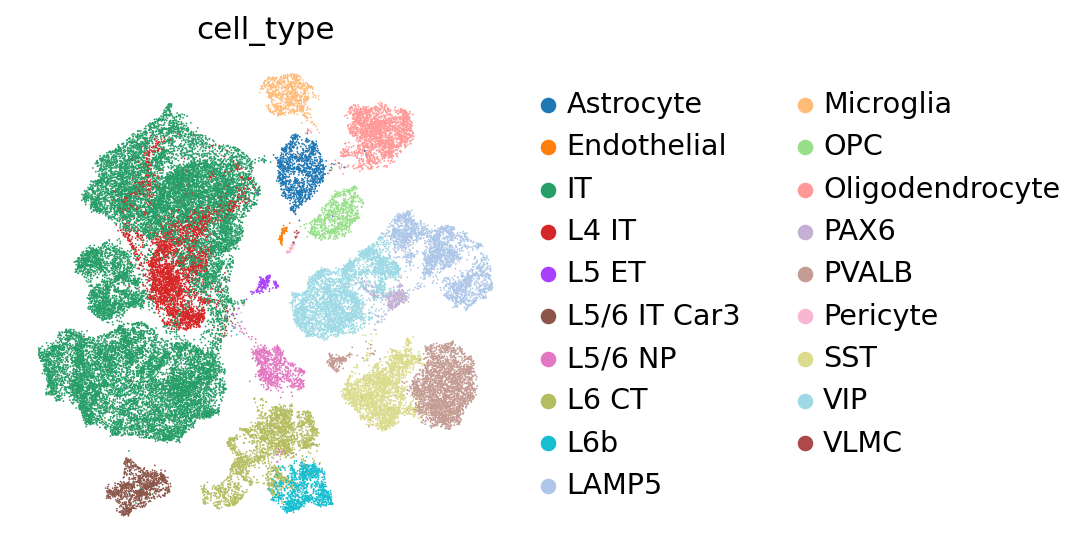

In [30]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [31]:
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.9562953280485748


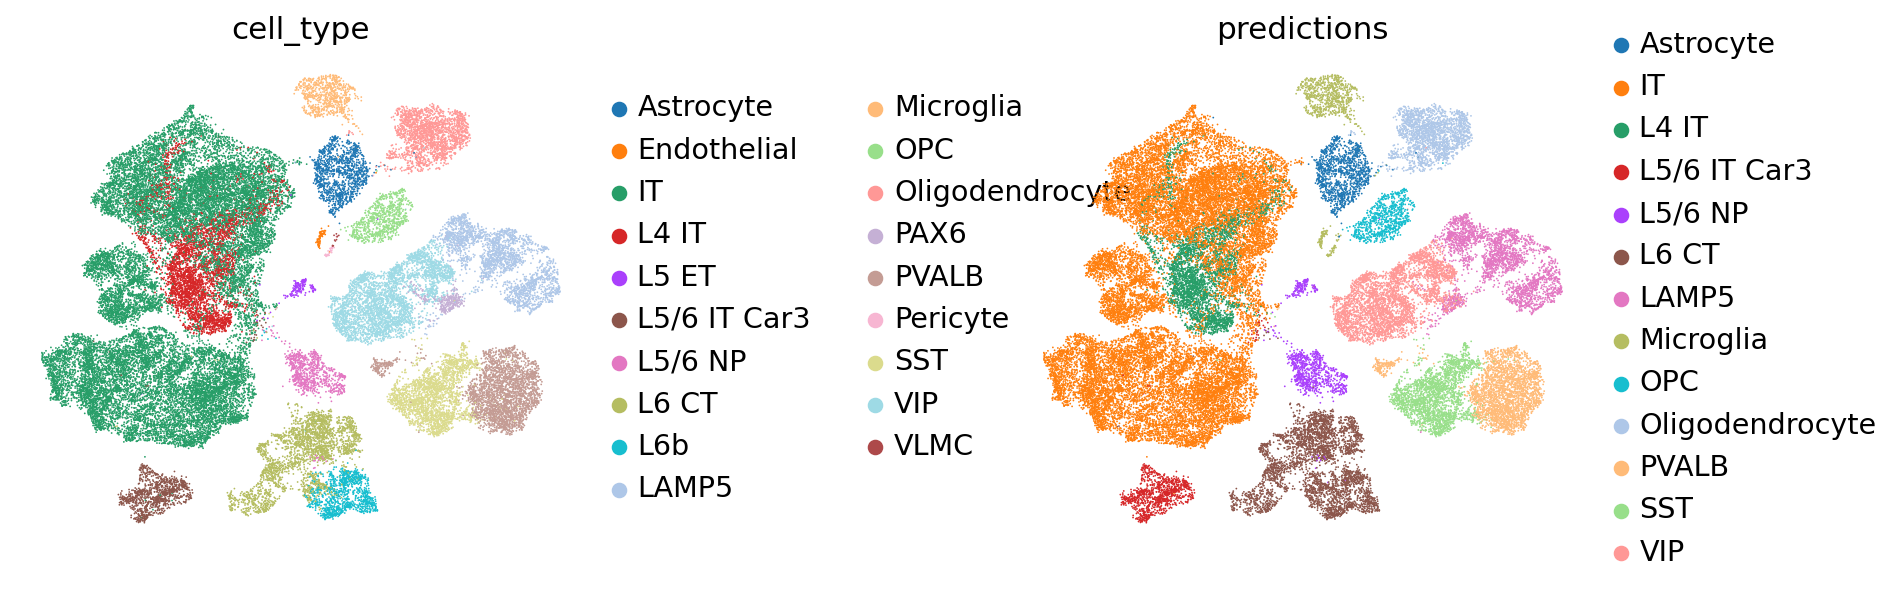

In [32]:
sc.pl.umap(reference_latent,
           color=['cell_type', 'predictions'],
           frameon=False,
           wspace=0.6,
           )

In [33]:
ref_path = 'ref_model_subclass_samplesFilt/'
scanvae.save(ref_path, overwrite=True)

# 3. Perform surgery on reference model and train on query dataset without cell type labels

In [34]:
target_adata.obs['subclass_label'] = scanvae.unlabeled_category_

In [35]:
model = sca.models.SCANVI.load_query_data(
    target_adata,
    ref_path
)

model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 812585 cells, 18930 vars, 16      
         batches, 20 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
Labelled Indices:  0
Unlabelled Indices:  812585


In [36]:
model.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 100/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [5:33:21<00:00, 200.01s/it, loss=6.99e+03, v_num=1]


In [37]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['leiden_r0.5'] = target_adata.obs['leiden_r0.5'].tolist()
#query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
#query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

<Figure size 320x320 with 0 Axes>

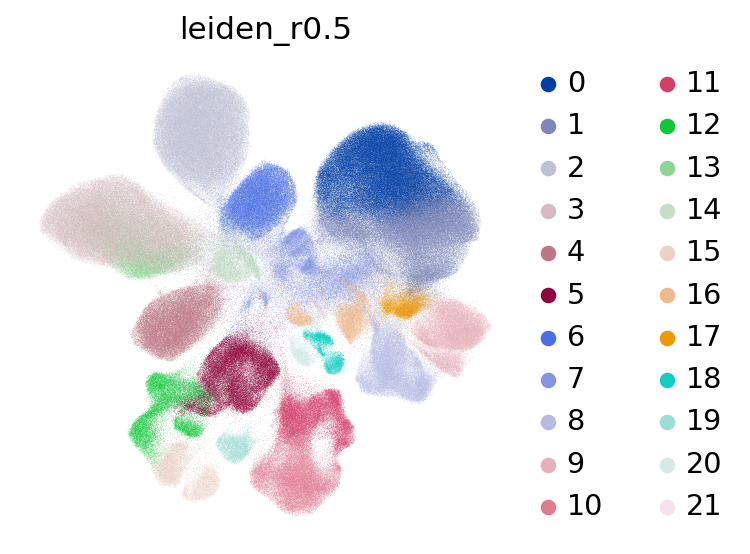

In [38]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["leiden_r0.5"],
    frameon=False,
    wspace=0.6,
)

In [39]:
surgery_path = 'surgery_model_subclass_samplesFilt'
model.save(surgery_path, overwrite=True)

In [40]:
query_latent.obs['predictions'] = model.predict()
#print("Acc: {}".format(np.mean(query_latent.obs.predictions == query_latent.obs.cell_type)))

<Figure size 320x320 with 0 Axes>

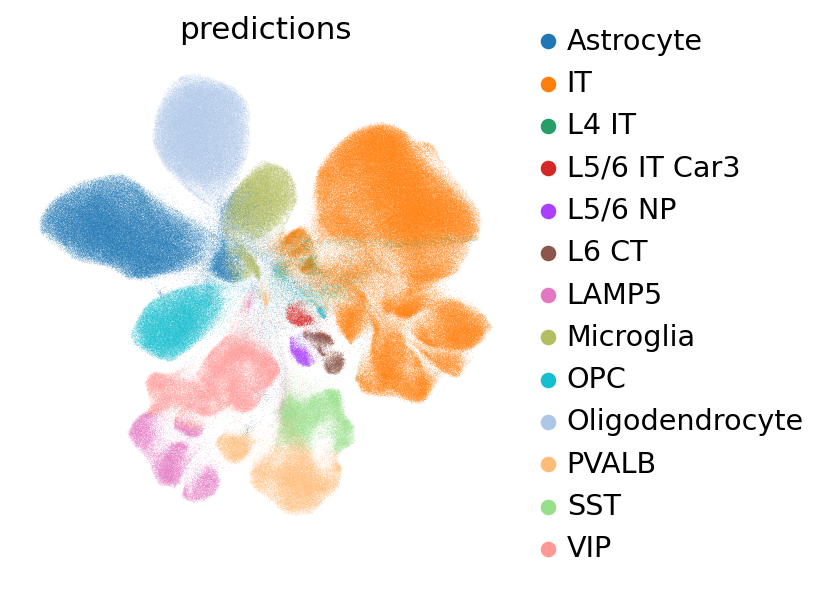

In [41]:
plt.figure()
sc.pl.umap(
    query_latent,
    color=["predictions"],
    frameon=False,
    wspace=0.6,
)

In [42]:
#Write data
query_latent.write(p['writedir']+'adata_labelTransfer_subclass_samplesFilt.h5ad')